In [1]:
import torch
import torch.optim as optim
import torchvision.models as models
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
import random
import os
import cv2
from tqdm import tqdm
from FNet import FNet
from utils import generate_region_masks, load_image, load_rgb
from utils import gaussian_kernel, coalition_perturbation

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
random_seed = 2
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

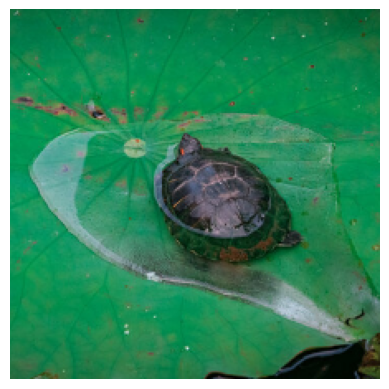

In [4]:
img_name = "turtle"
img_path = "sample/" + img_name + ".jpg"
im_rgb, im = load_rgb(img_path)

plt.imshow(im_rgb)
plt.axis('off')
plt.show()

In [5]:
folder_name = f'results_{img_name}'
os.makedirs(folder_name, exist_ok=True)

In [6]:
data = torch.from_numpy(np.array([im.transpose((2, 0, 1)).astype('float32')/255.]))
data = data.to(device)
data = Variable(data)

In [7]:
nCluster = 20

FNet = FNet(data.size(1), nCluster)
FNet.to(device)
FNet.train()

loss_fn = torch.nn.CrossEntropyLoss()

loss_y = torch.nn.L1Loss(size_average=True)
loss_z = torch.nn.L1Loss(size_average=True)

y_target = torch.zeros(im.shape[0]-1, im.shape[1], nCluster)
z_target = torch.zeros(im.shape[0], im.shape[1]-1, nCluster)
y_target = y_target.to(device)
z_target = z_target.to(device)
    
optimizer = optim.SGD(FNet.parameters(), lr=0.001, momentum=0.9)
label_colours = np.random.randint(255, size=(100, 3))

D:\anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
maxIter = 500
sim_loss = 1.0
consistancy_loss = 1.0
minLabels = 4

for batch_idx in tqdm(range(maxIter)):
    optimizer.zero_grad()
    output = FNet(data)[0]

    output = output.permute(1, 2, 0).contiguous().view(-1, nCluster)

    output_r = output.reshape((224, 224, nCluster))
    y = output_r[1:, :, :] - output_r[0: -1, :, :]
    z = output_r[:, 1:, :] - output_r[:, 0: -1, :]
    l_y = loss_y(y, y_target)
    l_z = loss_z(z, z_target)

    ignore, target = torch.max(output, 1)
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    
    loss = sim_loss * loss_fn(output, target) + consistancy_loss * (l_y + l_z)
        
    loss.backward()
    optimizer.step()

    if nLabels <= minLabels:
        print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
        break

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.57it/s]


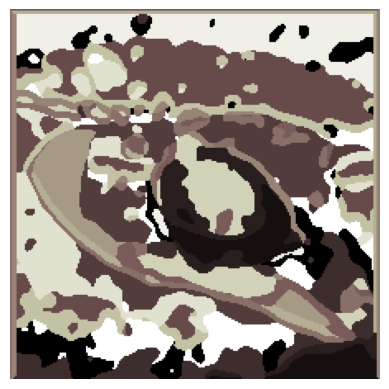

In [9]:
output = FNet(data)[0]
output = output.permute(1, 2, 0).contiguous().view(-1, nCluster)
ignore, target = torch.max(output, 1)
im_target = target.data.cpu().numpy()
cluster_labels = np.unique(im_target)
label_map = {label: idx for idx, label in enumerate(cluster_labels)}
im_target_mapped = np.vectorize(label_map.get)(im_target)
im_target_r_mapped = im_target_mapped.reshape(im.shape[:2])
im_target_rgb = ((im_target_r_mapped - im_target_r_mapped.min()) / (im_target_r_mapped.max() - im_target_r_mapped.min()) * 255).astype(np.uint8)
im_target_bone = cv2.applyColorMap(im_target_rgb, cv2.COLORMAP_BONE)
plt.imshow(im_target_bone)
plt.axis('off')
plt.savefig(f'results_{img_name}/coalitions.png', bbox_inches='tight', pad_inches=0)

In [10]:
np_array = np.random.randint(0, nLabels, (224, 224))
region_masks = generate_region_masks(im_target_r_mapped)

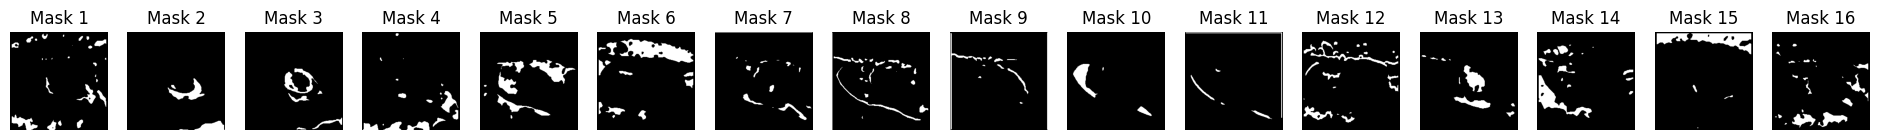

In [11]:
plt.figure(figsize=(24, 6))
    
for i in range(nLabels):
    mask = region_masks[i].squeeze().cpu().numpy() 
    
    plt.subplot(1, nLabels, i + 1)
    plt.imshow(mask[0], cmap='gray')
    plt.title(f'Mask {i + 1}')
    plt.axis('off')

    plt.imsave(f'results_{img_name}/mask_{i + 1}.png', mask[0], cmap='gray')

plt.show()

In [12]:
img = load_image(img_path)
model = models.vgg16(models.VGG16_Weights.IMAGENET1K_V1).to(device)
model.eval()

cls, prob, mask, res = coalition_perturbation(img, region_masks, model, device, w_weight=0.1, conf_weight=100.0, continuity_weight=1.0, c_weight=0.0, max_iter=500, batch_size=16, step_size=1e-2, max_w=1)
saliency_map = 1 - np.mean(mask[0, :, :, :], axis=0)

D:\anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:37<00:00,  5.11it/s]


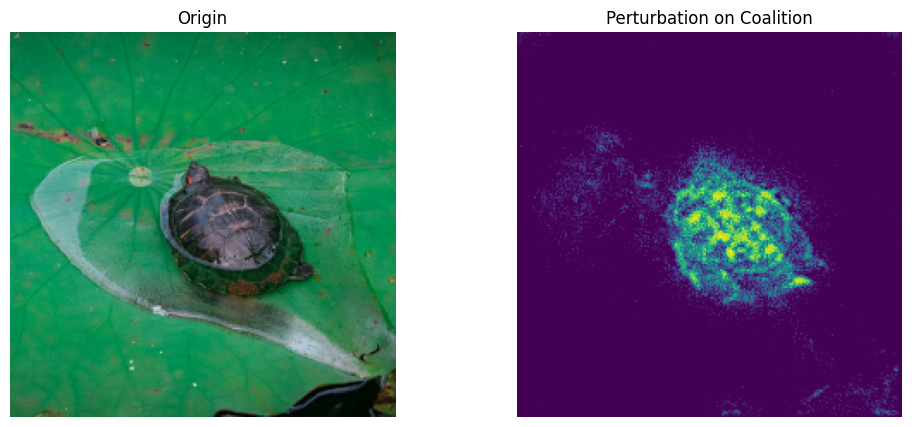

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(im_rgb)
plt.axis('off')
plt.title('Origin')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map)
plt.axis('off')
plt.title('Perturbation on Coalition')

plt.savefig(f'results_{img_name}/result.png', bbox_inches='tight')

plt.show()